In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hc_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all_csvs/mpfc_csvs"
brain_region = '#FFAF00'

# NAc: #15616F
# mPFC: #FFAF00

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc/p6-240823-105552/Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc/p2-240508-101128/Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc/pp4-250121-065035/Notes.txt
read from t=0s to t=1876.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc/p7-240824-053845/Notes.txt
read from t=0s to t=1790.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/mpfc/pp5-250121-110144/Notes.txt
read from t=0s to t=1895.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for p6-240823-105552...
Processing behaviors for p2-240508-101128...
Processing behaviors for pp4-250121-065035...
Processing behaviors for p7-240824-053845...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp6-250121-114116...
Processing behaviors for p1-240508-084607...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Processing behaviors for p5-240823-093250...
Processing behaviors for p3-240509-070801...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp2-250121-123301...
Processing behaviors for p4-240509-083601...


## Total Investigation Time & Average Bout Duration

In [5]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes


def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [6]:
get_trial_dataframes(experiment)

[            Bout       Behavior  Event_Start  Event_End  Duration (s)
 0    Long_Term-1       Approach       1254.4   1255.699         1.299
 1    Long_Term-1       Approach       1269.1   1270.499         1.399
 2    Long_Term-1       Approach       1373.4   1374.999         1.599
 3    Long_Term-1  Investigation       1182.5   1183.800         1.300
 4    Long_Term-1  Investigation       1185.3   1188.100         2.800
 5    Long_Term-1  Investigation       1196.6   1197.500         0.900
 6    Long_Term-1  Investigation       1246.1   1247.100         1.000
 7    Long_Term-1  Investigation       1255.7   1256.200         0.500
 8    Long_Term-1  Investigation       1257.7   1260.100         2.400
 9    Long_Term-1  Investigation       1270.5   1272.400         1.900
 10   Long_Term-1  Investigation       1305.9   1306.100         0.200
 11   Long_Term-1  Investigation       1334.6   1336.700         2.100
 12   Long_Term-1  Investigation       1375.0   1376.100         1.100
 13   

In [7]:
desired_bouts = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [8]:
# Define the desired order of the bars
desired_order = ["Acq-ST", "Short Term", "Long Term", "Novel"]

# Map original bout names to new labels
bout_rename_mapping = {
    "Short_Term-1": "Acq-ST",
    "Short_Term-2": "Short Term",
    "Long_Term-1": "Long Term",
    "Novel-1": "Novel"
}

# Rename columns in pivot_df
pivot_df = pivot.rename(columns=bout_rename_mapping)

# Reorder columns based on desired order
pivot_df = pivot_df[desired_order]

In [9]:
def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    """
    Plots the mean values during investigations or other events across bouts with error bars for SEM,
    and individual subject lines connecting the bouts. All subjects are plotted in gray.

    Performs t-tests and plots significance markers above bars.
    """

    def perform_t_tests(df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel using pivot_df."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in df.columns and bout2 in df.columns:
                # Drop NaN values and ensure equal-length pairs
                paired_df = df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:  # Ensure enough data points for paired t-test
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Compute t-test results using the nested function
    t_test_results = perform_t_tests(df)

    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust to separate significance lines
        current_y = mean_values.max() + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show()

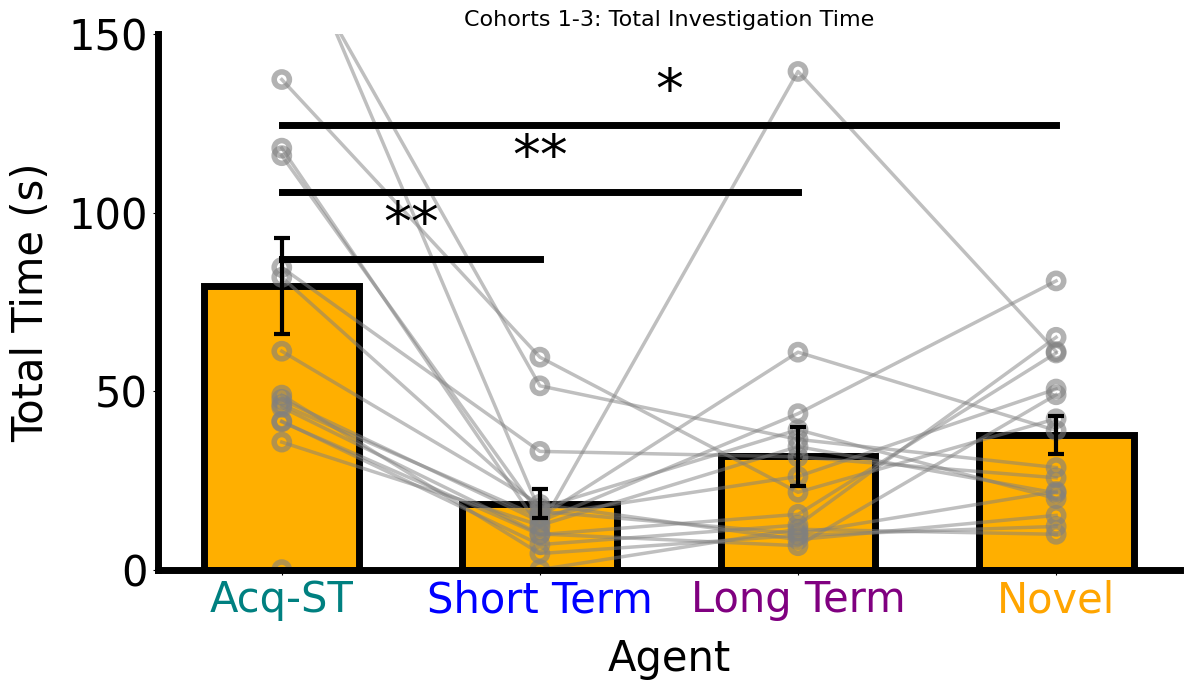

In [10]:
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Cohorts 1-3: Total Investigation Time",
    ylabel="Total Time (s)",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 150),
    bar_color=brain_region,
    yticks_increment=50,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1
)

## Global DA

In [11]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=None                 # Consider only the first investigation event per bout
)

Processing behaviors for p6-240823-105552...
Processing behaviors for p2-240508-101128...
Processing behaviors for pp4-250121-065035...
Processing behaviors for p7-240824-053845...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp6-250121-114116...
Processing behaviors for p1-240508-084607...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Processing behaviors for p5-240823-093250...
Processing behaviors for p3-240509-070801...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp2-250121-123301...
Processing behaviors for p4-240509-083601...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp3-250121-0552

In [22]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots DA metrics across specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above bars.

    Updates:
    - Unfilled circle markers for individual trials
    - Thick grey outlines for visibility
    """

    def perform_t_tests(pivot_df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in pivot_df.columns and bout2 in pivot_df.columns:
                paired_df = pivot_df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Collect per-trial data for the chosen metric
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            trial_df = trial.behaviors.copy()
            if metric_name not in trial_df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = trial_df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Select only 6 bouts
    selected_bouts = combined_df["Bout"].unique()[:6]
    combined_df = combined_df[combined_df["Bout"].isin(selected_bouts)]

    # Pivot the data for line plots: rows=Trial, columns=Bout, values=metric_name
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name).fillna(0)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return

    # Compute overall average and SEM for each Bout
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Now that pivot_df is created, perform t-tests
    t_test_results = perform_t_tests(pivot_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray)
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Set labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=28)

    # Set exactly 6 x-tick labels
    xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"]
    xtick_colors=["teal", "blue", "purple", "orange"]

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(xtick_labels, fontsize=28)

    # Apply custom colors
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_values) * 1.2)
    else:
        ax.set_ylim(ylim)

    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Set y-ticks increment
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust spacing between lines
        current_y = np.nanmax(overall_stats["mean"]) + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


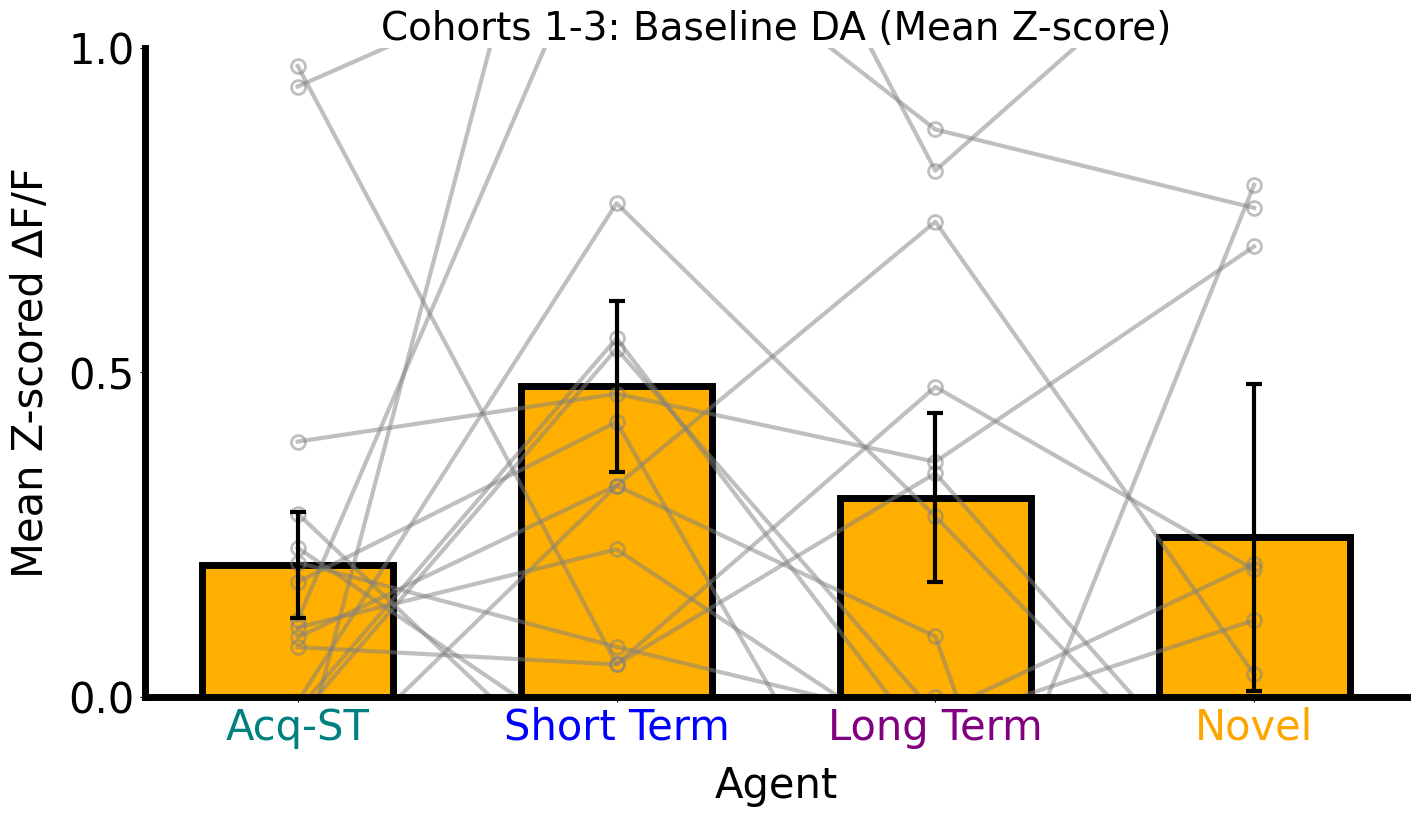

In [21]:
from scipy.stats import ttest_rel

plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Cohorts 1-3: Baseline DA (Mean Z-score)", 
                                                ylabel="Mean Z-scored ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(0, 1), 
                                                bar_color=brain_region, 
                                                yticks_increment=0.5, 
                                                figsize=(14,8), 
                                                pad_inches=0.1)

# Mean Z-scored ∆F/F